In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [240]:
data = pd.read_csv('day.csv')
data.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


In [241]:
data = data.drop(['casual', 'registered', 'instant', 'dteday'], axis=1)

#Mapping categorical variables from numerical to more readable string as we are to one hot encode them soon.

data['weekday'] = data['weekday'].map({0:'sunday', 1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5: 'friday', 6:'saturday'})

data['weathersit'] = data['weathersit'].map({ 1: 'clear', 2: 'mist_cloudy', 3:'light_weather', 4:'heavy_weather'})

data['season'] = data['season'].map({1: 'spring', 2:'summer', 3:'fall', 4:'winter'})

data['mnth'] = data['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sept', 10: 'oct', 11:'nov', 12:'dec'})



# Data Visualization
- Perform EDA to understand various variables
- Check the correlation between variables

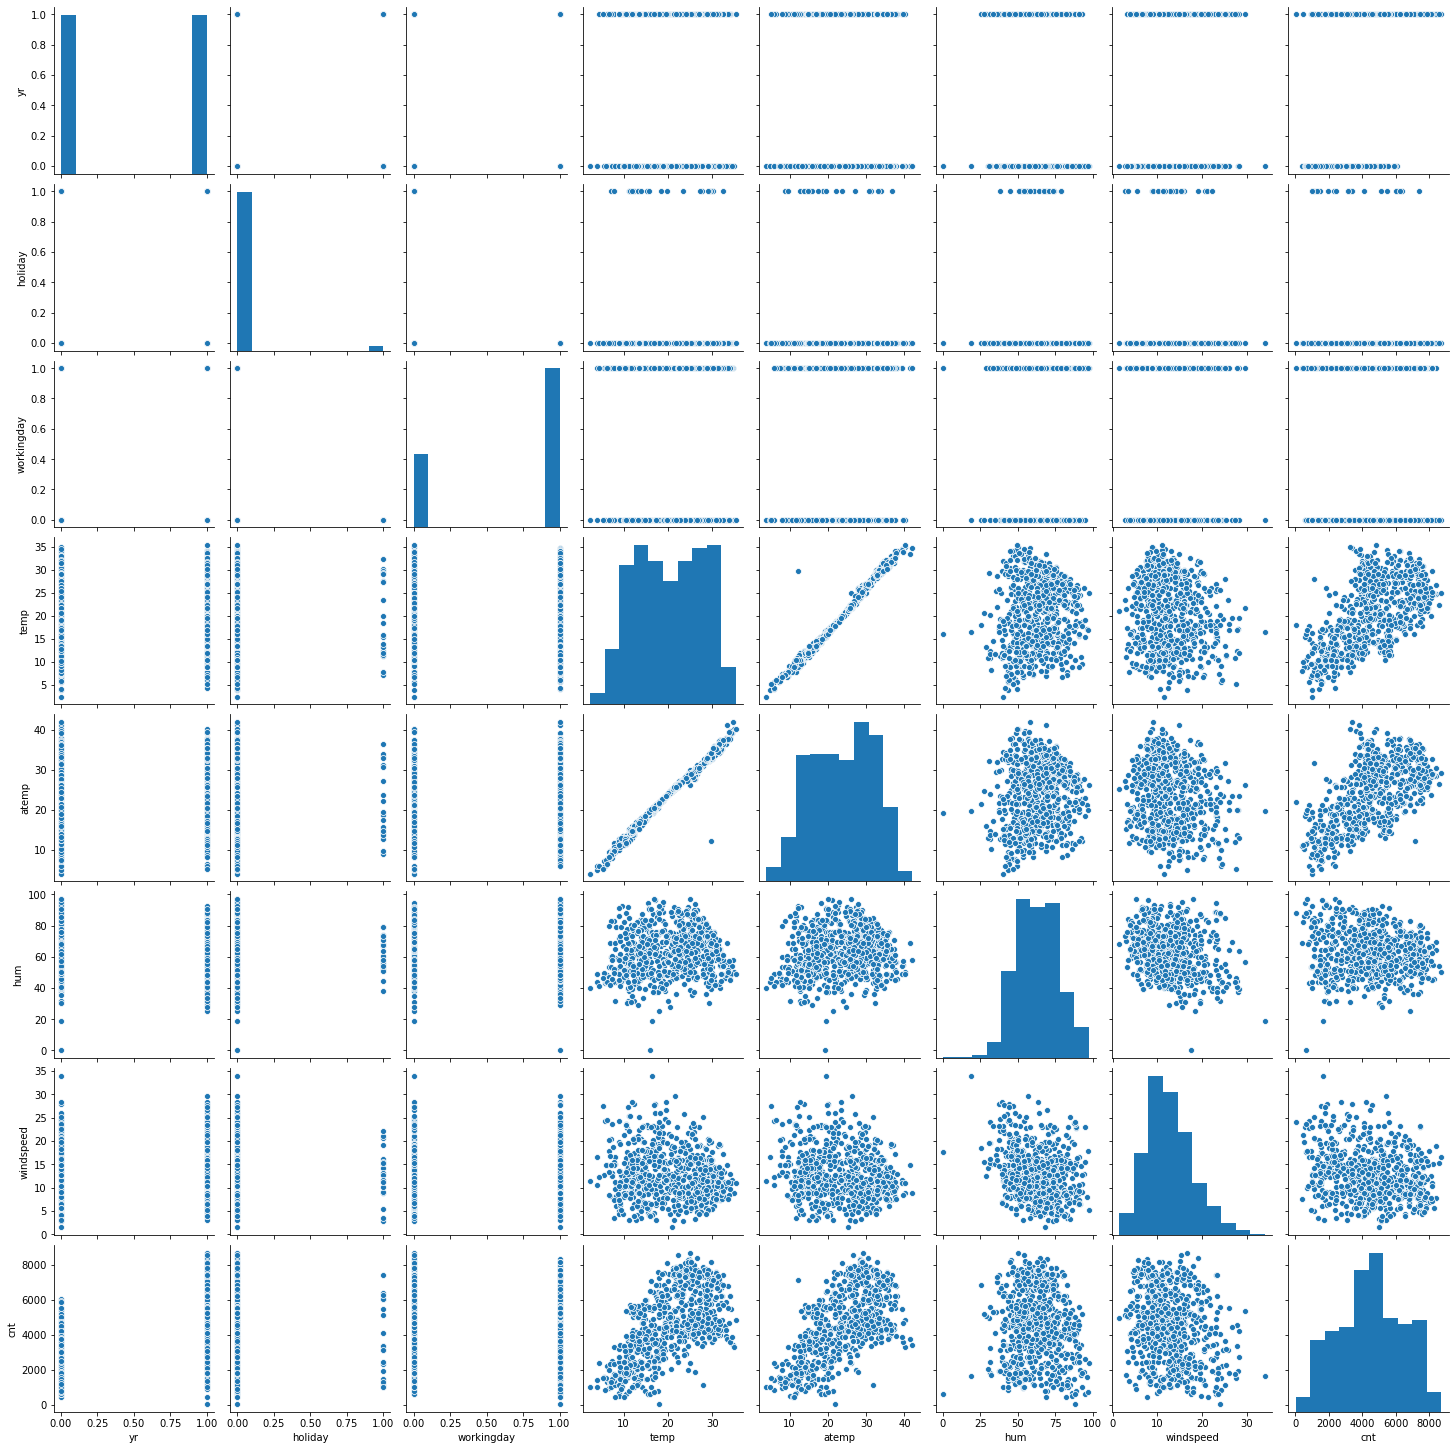

In [237]:
#pairplot
# Lets check whether the independent vriables have linear relation with their target variable 'cnt'
# Let's also check if multicollinearity exists between predictor variables
sns.pairplot(data)
plt.show()

### Remarks:

From the pairplot above we can observe that the feature 'hum' and 'windspeed' has weak negative linear relation with the target variable 'cnt'; rest of the variables seems to have adequate linear relationip with 'cnt'. So we can expect first condition of our regresion is well met.

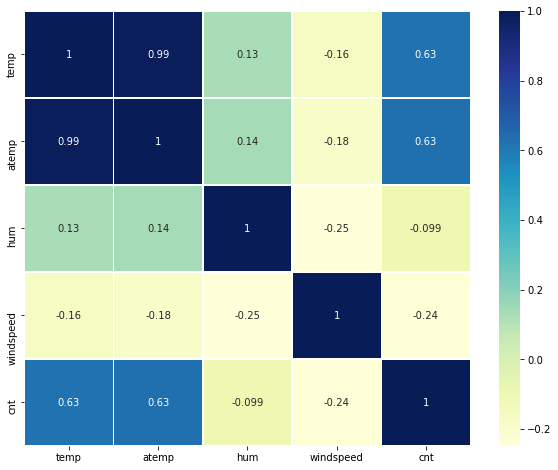

In [242]:
continuous_var = ['temp','atemp','hum','windspeed','cnt']
plt.figure(figsize=(10,8))
sns.heatmap(data[continuous_var].corr(), annot=True, cmap="YlGnBu", linewidth=0.5)
plt.show()

### Remarks:
From the pairplot as well as the heatmap above, we see there is a strong positive correlation between the variables `temp` and `atemp.` So we should drom one of them.

In [181]:
data= data.drop('atemp', axis=1) #dropping atemp (adjusted temperature) which is the feeling temperature in celcius

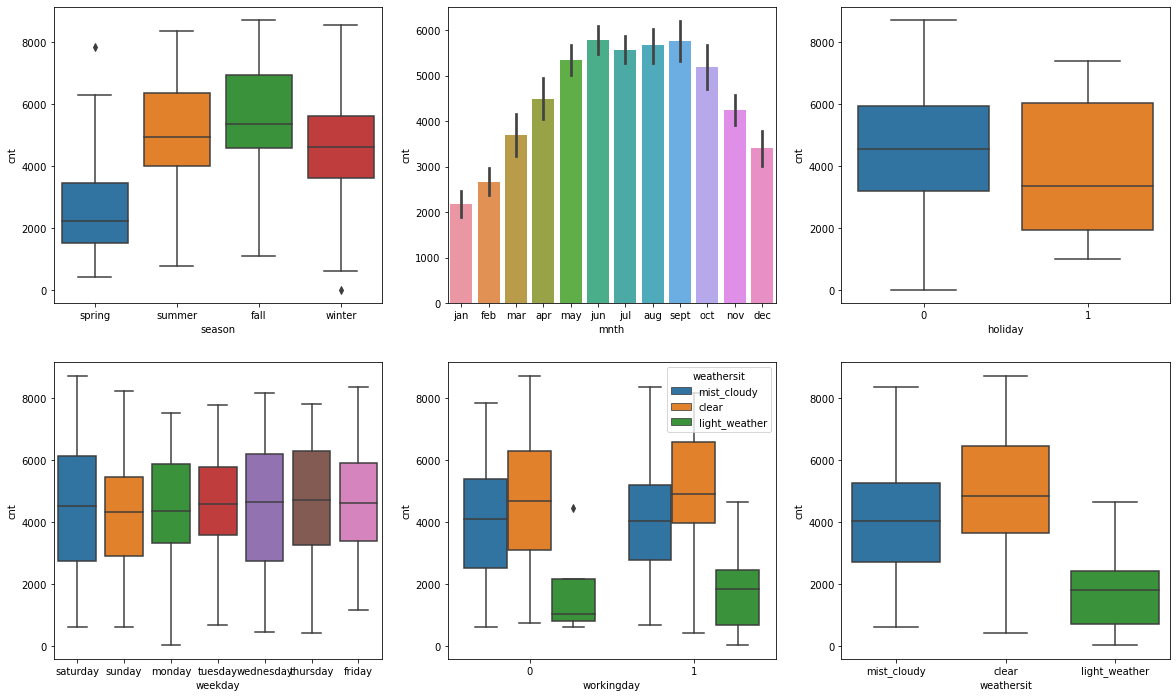

In [182]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(data=data, y='cnt', x='season')
plt.subplot(2,3,2)
sns.barplot(data=data, y='cnt' ,x='mnth')
plt.subplot(2,3,3)
sns.boxplot(data=data, y='cnt' ,x='holiday')
plt.subplot(2,3,4)
sns.boxplot(data=data, y='cnt' ,x='weekday')
plt.subplot(2,3,5)
sns.boxplot(data=data, y='cnt' ,x='workingday', hue='weathersit')
plt.subplot(2,3,6)
sns.boxplot(data=data, y='cnt' ,x='weathersit')
plt.show()

### Remarks:

- Demand tends to pick up in spring and reach its peak in fall however tends to decline and reach its lowest at winter.`fig:1)`

- June to September demand seems to experience its upper bound. `(fig:2)`

- Demand tends to be lower in holidays, however demand for cheaper rides or shortdistance rides seems more prevalent in holidays. `(fig:3)`

- sunday and Wednesday seems promising days of the week. `(fig:4)`

- Weather situation be clear or mist_cloudy, doesn't seem to affect demand neither in workingdays or weekends. However, light snow, light rain, thunderstorm makes the difference. `(fig:5)`

- Given the limited records of data, what we can infer is that demand tends to be high during clear weather situation, falls a little in mist cloudy weather, but falls dramatically during light snow or rainy weaher. `(fig6)`

# Data Preparation

- Create dummy variables for all the categorical features
- Divide the data to train and test
- Perform Scaling
- Divide the data into X and y

In [183]:
dummies1 = pd.get_dummies(data['mnth'], drop_first=True)
dummies2 = pd.get_dummies(data['season'], drop_first=True)
dummies3 = pd.get_dummies(data['weekday'], drop_first=True)
dummies4 = pd.get_dummies(data['weathersit'], drop_first=True)

data = data.drop(['mnth', 'season', 'weekday', 'weathersit'], axis= 1)

data = pd.concat([data, dummies1, dummies2, dummies3, dummies4], axis=1)

In [184]:
data.head(5)

,yr,holiday,workingday,temp,hum,windspeed,cnt,aug,dec,feb,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,light_weather,mist_cloudy
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [243]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [186]:
#Divide the data to train and test

#np.random.seed(0)
data_train, data_test = train_test_split(data, train_size= 0.7, test_size= 0.3, random_state = 100)

print(data_train.shape)
print(data_test.shape)

(510, 29)
(219, 29)


In [187]:
#Perform Scaling
var = ['temp','hum','windspeed', 'cnt'] 

scale = MinMaxScaler() #minmax is good at handling outliers, 'hum' has one outlier value i.e- 0

data_train[var] = scale.fit_transform(data_train[var])

In [188]:
#Divide the data into X and y
y_train = data_train.pop('cnt')
x_train = data_train

In [189]:
x_train.head(5)

,yr,holiday,workingday,temp,hum,windspeed,aug,dec,feb,jan,...,summer,winter,monday,saturday,sunday,thursday,tuesday,wednesday,light_weather,mist_cloudy
653,1,0,1,0.509887,0.575354,0.300794,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


# Data Modelling & Evaluation
- Create Linear Regresion model using `mixed approach(RFE and VIF/p-value)`
- Check the various assumptions
- Check the Adjusted R-square for both train and test data
- Report the final model

### Feature Selection (automated approach)

In [244]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [245]:
rfe = RFE(lm, 12)
rfe = rfe.fit(x_train, y_train)

In [246]:
col = x_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'jul', 'sept', 'spring',
       'summer', 'winter', 'light_weather', 'mist_cloudy'],
      dtype='object')

In [247]:
#ranking features
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('aug', False, 9),
 ('dec', False, 6),
 ('feb', False, 7),
 ('jan', False, 4),
 ('jul', True, 1),
 ('jun', False, 16),
 ('mar', False, 17),
 ('may', False, 8),
 ('nov', False, 5),
 ('oct', False, 13),
 ('sept', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('monday', False, 11),
 ('saturday', False, 2),
 ('sunday', False, 10),
 ('thursday', False, 14),
 ('tuesday', False, 12),
 ('wednesday', False, 15),
 ('light_weather', True, 1),
 ('mist_cloudy', True, 1)]

In [248]:
x_train_rfe = x_train[col]
x_train_lr_rfe = sm.add_constant(x_train_rfe)
x_train_lm_rfe = sm.OLS(y_train, x_train_lr_rfe)
rfe_lm = x_train_lm_rfe.fit()
print(rfe_lm.summary())

vif = pd.DataFrame()
vif['features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     221.2
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.69e-190
Time:                        21:26:55   Log-Likelihood:                 509.47
No. Observations:                 510   AIC:                            -992.9
Df Residuals:                     497   BIC:                            -937.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2841      0.034      8.242

In [249]:
x_train_rfe = x_train_rfe.drop('hum', axis=1)

x_train_lr_rfe = sm.add_constant(x_train_rfe)
x_train_lm_rfe = sm.OLS(y_train, x_train_lr_rfe)
rfe_lm = x_train_lm_rfe.fit()
print(rfe_lm.summary())

vif = pd.DataFrame()
vif['features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.40e-187
Time:                        21:26:55   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1996      0.030      6.758

In [250]:
x_train_rfe = x_train_rfe.drop('jul', axis=1)

x_train_lr_rfe = sm.add_constant(x_train_rfe)
x_train_lm_rfe = sm.OLS(y_train, x_train_lr_rfe)
rfe_lm = x_train_lm_rfe.fit()
print(rfe_lm.summary())

vif = pd.DataFrame()
vif['features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          7.36e-187
Time:                        21:26:56   Log-Likelihood:                 495.16
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     499   BIC:                            -921.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1910      0.030      6.456

In [251]:
x_train_rfe = x_train_rfe.drop('sept', axis=1)

x_train_lr_rfe = sm.add_constant(x_train_rfe)
x_train_lm_rfe = sm.OLS(y_train, x_train_lr_rfe)
rfe_lm = x_train_lm_rfe.fit()
print(rfe_lm.summary())

vif = pd.DataFrame()
vif['features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     258.0
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.42e-181
Time:                        21:26:56   Log-Likelihood:                 479.80
No. Observations:                 510   AIC:                            -939.6
Df Residuals:                     500   BIC:                            -897.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2223      0.030      7.436

### Remarks
- In the training dataset, R-Squared is 0.823 and Adjusted R-Squared 0.820, it indicates that none of the parameters in this model are redundant, so there is no extra variable that I've added.

### Feature Selection (Manual approach)

Note: In manual approach I have prioritized dropping variable in the following basis:
1. High p-value, High-VIF
2. High p-value, Low VIF
3. Low p-value, High VIF
4. Low p-value, Low VIF (depending on understanding of business domain)

In [252]:
#1
x_train_lr = sm.add_constant(x_train)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     103.8
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          8.74e-182
Time:                        21:26:58   Log-Likelihood:                 527.95
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     482   BIC:                            -881.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2451      0.035      6.955

### `HIGH P-Value High VIF`

In [253]:
#2

x = x_train.drop('oct', axis=1) #High P-Value High-VIF

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     108.0
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          8.50e-183
Time:                        21:26:59   Log-Likelihood:                 527.93
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     483   BIC:                            -887.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2476      0.033      7.495

In [254]:
#3

x = x.drop('summer', axis=1) #High P-Value, High VIF


x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     112.0
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.55e-183
Time:                        21:26:59   Log-Likelihood:                 526.69
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     484   BIC:                            -891.3
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2758      0.028     10.021

### `High P-Value Low VIF`

In [255]:
#4
x = x.drop('mar', axis=1) #dropping Mar as it has p-value 0.978

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     116.9
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.33e-184
Time:                        21:27:00   Log-Likelihood:                 526.69
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     485   BIC:                            -897.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2756      0.026     10.432

In [256]:
#5
x = x.drop('wednesday', axis=1) #dropping wednesday as it has p-value 0.748

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.2
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.19e-185
Time:                        21:27:00   Log-Likelihood:                 526.64
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     486   BIC:                            -903.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2748      0.026     10.453

In [257]:
#6
x = x.drop('jun', axis=1) #dropping jun as it has p-value 0.621

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     127.9
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.16e-186
Time:                        21:27:00   Log-Likelihood:                 526.51
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     487   BIC:                            -909.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2759      0.026     10.536

In [258]:
#7
x = x.drop('thursday', axis=1) #dropping thursday as it has p-value 0.616

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.2
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.09e-187
Time:                        21:27:00   Log-Likelihood:                 526.38
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     488   BIC:                            -915.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2748      0.026     10.538

In [259]:
#8
x = x.drop('aug', axis=1) #dropping aug as it has p-value 0.524

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     141.1
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.12e-188
Time:                        21:27:01   Log-Likelihood:                 526.16
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     489   BIC:                            -921.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2768      0.026     10.697

In [260]:
#9
x = x.drop('holiday', axis=1) #dropping holiday as it has p-value 0.464

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     141.1
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.12e-188
Time:                        21:27:01   Log-Likelihood:                 526.16
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     489   BIC:                            -921.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2932      0.042      7.042

In [261]:
#10
x = x.drop('tuesday', axis=1)  #dropping tuesday as it has p-value 0.271

x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)

print('\n')
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.3
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          3.14e-189
Time:                        21:27:01   Log-Likelihood:                 525.53
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2915      0.042      7.005

In [262]:
#11
x = x.drop('monday', axis=1)  #dropping monday as it has p-value 0.280
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     156.5
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          4.42e-190
Time:                        21:27:01   Log-Likelihood:                 524.92
No. Observations:                 510   AIC:                            -1012.
Df Residuals:                     491   BIC:                            -931.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2814      0.041      6.938

In [263]:
#12
x = x.drop('sunday', axis=1) #dropping sunday as it has p-value 0.075
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.8
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.65e-190
Time:                        21:27:02   Log-Likelihood:                 523.27
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     492   BIC:                            -934.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3236      0.033      9.788

### `Low P-Value, High VIF`

In [264]:
#13
x = x.drop('hum', axis=1)  #Low P-Value High VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.1
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.42e-188
Time:                        21:27:02   Log-Likelihood:                 515.38
No. Observations:                 510   AIC:                            -996.8
Df Residuals:                     493   BIC:                            -924.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2473      0.027      9.108

### `High P-value Low VIF`

In [265]:
#14 

x = x.drop('may', axis=1)  #High P-value Low VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          8.46e-189
Time:                        21:27:03   Log-Likelihood:                 513.76
No. Observations:                 510   AIC:                            -995.5
Df Residuals:                     494   BIC:                            -927.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2546      0.027      9.470

### `Low P-Value High VIF`

In [266]:
#15
x = x.drop('temp', axis=1)  #dropping temp for high VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     142.7
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.50e-163
Time:                        21:27:04   Log-Likelihood:                 450.80
No. Observations:                 510   AIC:                            -871.6
Df Residuals:                     495   BIC:                            -808.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5199      0.017     31.439

### `High P-Value Low VIF`

In [267]:
#16
x = x.drop('jul', axis=1) #low P-Value High VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     153.7
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.73e-164
Time:                        21:27:05   Log-Likelihood:                 450.41
No. Observations:                 510   AIC:                            -872.8
Df Residuals:                     496   BIC:                            -813.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5237      0.016     32.809

In [268]:
#17
x = x.drop('winter', axis=1) #High P-value Low VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     166.4
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.24e-165
Time:                        21:27:05   Log-Likelihood:                 449.86
No. Observations:                 510   AIC:                            -873.7
Df Residuals:                     497   BIC:                            -818.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5270      0.016     33.723

### `Low p-value, Low VIF (depending on understanding of business domain)`

In [269]:
#18
x = x.drop('jan', axis=1) #Low p-value, Low VIF (depending on understanding of business domain)
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     158.8
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          5.81e-155
Time:                        21:27:06   Log-Likelihood:                 422.48
No. Observations:                 510   AIC:                            -821.0
Df Residuals:                     498   BIC:                            -770.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5172      0.016     31.507

In [270]:
#19
x = x.drop('feb', axis=1) #High P-Value low VIF
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     174.9
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          4.85e-156
Time:                        21:27:07   Log-Likelihood:                 422.35
No. Observations:                 510   AIC:                            -822.7
Df Residuals:                     499   BIC:                            -776.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5170      0.016     31.526

In [271]:
#20
x = x.drop('nov', axis=1) #Low p-value, Low VIF (depending on understanding of business domain)
x_train_lr = sm.add_constant(x)
x_train_lm = sm.OLS(y_train, x_train_lr)
linear_model = x_train_lm.fit()
print(linear_model.summary())

vif = pd.DataFrame()
vif['features'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     181.0
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          4.18e-151
Time:                        21:27:07   Log-Likelihood:                 407.98
No. Observations:                 510   AIC:                            -796.0
Df Residuals:                     500   BIC:                            -753.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5007      0.017     30.235

### Remarks:

- Using manual feature selection process, after building `20 models` finally we now have model with 9 features with `R-Squared 0.765` and `Adjusted R-Squared 0.761.`
- Meanwhile using RFE we have finalized a model which has `R-Squared 0.823` and `Adjusted R-Squared 0.820.`

Before selecting which model to choose for the test data set we will go through $Residual Analysis$ to check if the error terms of both models meet the following conditions. The conditions are:
        1. Error terms are normally distributed with mean 0.
        2. Error terms are independent of each other.
        3. Error terms have constant variance.

In [279]:
print('Feature Selection after automated approach:','\n', '\n',x_train_rfe.columns, '\n')
print('\n','Feature Selection after manual approach:','\n', '\n',x.columns)

Feature Selection after automated approach: 
 
 Index(['yr', 'holiday', 'temp', 'windspeed', 'spring', 'summer', 'winter',
       'light_weather', 'mist_cloudy'],
      dtype='object') 


 Feature Selection after manual approach: 
 
 Index(['yr', 'workingday', 'windspeed', 'dec', 'sept', 'spring', 'saturday',
       'light_weather', 'mist_cloudy'],
      dtype='object')


## Residual Analysis

In [272]:
x_train_final = x_train[x.columns]

In [273]:
y_train_pred = linear_model.predict(x_train_lr) #Manual approach
y_pred_rfe = rfe_lm.predict(x_train_lr_rfe) #Automated (RFE) approach

In [274]:
res_automated = y_train - y_pred_rfe
res_manual = y_train - y_train_pred

### `RESIDUAL ANALYSIS ON FEATURES SELECTED THROUGH AUTOMATED APPROACH`

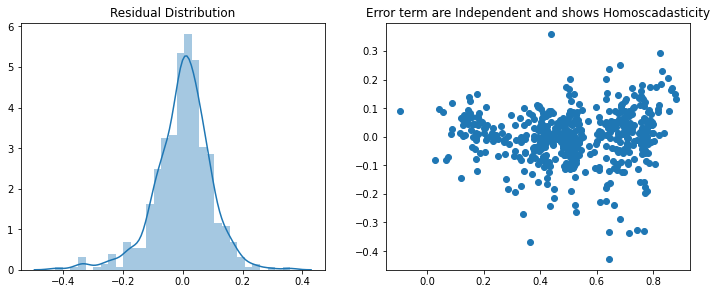

In [275]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.distplot(res_automated)
plt.title('Residual Distribution')
plt.subplot(2,2,2)
plt.scatter(x=y_train_pred, y=res_automated)
plt.title('Error term are Independent and shows Homoscadasticity')
plt.show()


### `RESIDUAL ANALYSIS ON FEATURES SELECTED THROUGH MANUAL APPROACH`

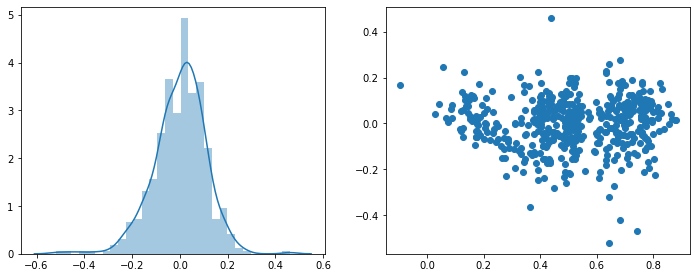

In [276]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.distplot(res_manual)
plt.subplot(2,2,2)
plt.scatter(x=y_train_pred, y=res_manual)
plt.show()


In [278]:
print('Feature Selection after automated approach:','\n', '\n',x_train_rfe.columns, '\n')
print('\n','Feature Selection after manual approach:','\n', '\n',x.columns)

Feature Selection after automated approach: 
 
 Index(['yr', 'holiday', 'temp', 'windspeed', 'spring', 'summer', 'winter',
       'light_weather', 'mist_cloudy'],
      dtype='object') 


 Feature Selection after manual approach: 
 
 Index(['yr', 'workingday', 'windspeed', 'dec', 'sept', 'spring', 'saturday',
       'light_weather', 'mist_cloudy'],
      dtype='object')


### REMARKS:

Error terms of both models meet the three assumptions we wanted to analyse on. Now judging on business domain knowledge, features finalized through automated(using RFE) approach seems more promising to work with, and not only that, it has higher R-squared value and the difference between R-squared and Adjusted R-Squared is 0.003 which tells us that the features we finalized in that model are not redundant. Features finalized through manual feature selection approach has features like months and day 0f the week which has less meaningful interpretation to contribute to the model for Boombike managment board to understand.

# Prediction and Evaluation

In [225]:
data_test[var] = scale.transform(data_test[var])

In [226]:
y_test = data_test.pop('cnt')
x_test = data_test

In [227]:
x_test_lr = sm.add_constant(x_test[x_train_rfe.columns])
y_test_pred = rfe_lm.predict(x_test_lr)

Text(0, 0.5, 'y_test')

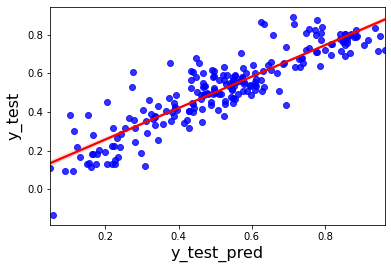

In [228]:
sns.regplot(x=y_test, y=y_test_pred, ci=68, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('y_test_pred', fontsize=16)
plt.ylabel('y_test', fontsize=16)

In [280]:
#Mean Squared Error

mean_squared_error(y_test, y_test_pred)

0.009452972491040733

In [281]:
#R-squared 
r2_score(y_true= y_test, y_pred= y_test_pred)

0.8009724887482658

### Remarks: 
with R-squared is 0.80 in test set and 0.823 in training set, we can conclude that what the model has learned in the training set, can very well generalize in the test set.

# Summary: 


- Model Selected: RFE approach
- R-Squared: 0.823
- Adjusted R-Squared: 0.820
- R2_Score (y_test, y_test_pred): 0.8009
- Mean Squared Error: 0.00945

So we see that the equation of our best fitted line is:

`cnt =  0.2223 + (0.2340 x'yr') - (0.0877 x 'holiday') + (0.4667 x 'temp') - (0.1546 x 'windspeed') - (0.0824 x 'spring') + (0.0371 x 'summer') + (0.0760 x 'winter') - (0.2794 x 'light_weather') - (0.0763 x 'mist_cloudy')`

In [282]:
#print(rfe_lm.summary())